In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from datetime import datetime

from scipy.optimize import curve_fit

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [3]:
from scipy.special import erf

def gaus(x, x0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - x0)**2 / (2 * sigma**2))

def search_expectation(x0, alpha, amp2kev, sig_amp):
    sigma = sig_amp * amp2kev
    bias = alpha * sigma

    first = bias * 0.5 * ( erf((bias - x0)/(np.sqrt(2) * sigma)) - erf((-1 * bias - x0)/(np.sqrt(2) * sigma)) )

    xx0 = np.linspace(bias, x0 + 5*sigma, 1000)
    second = np.trapz(gaus(xx0, x0, sigma) * np.abs(xx0), xx0, axis=0)

    xx1 = np.linspace(x0 - 5*sigma, -1 * bias, 1000)
    third = np.trapz(gaus(xx1, x0, sigma) * np.abs(xx1), xx1, axis=0)

    return (first + second + third) / amp2kev

In [4]:
def get_detection_efficiency(normalized_amps, sigmas, threshold=5):
    eff, eff_err = [], []
    for i, amps in enumerate(normalized_amps):
        count = np.count_nonzero(amps > threshold * sigmas[i])
        eff.append(count / amps.size)
        eff_err.append(np.sqrt(count) / amps.size)

    return eff, eff_err

def func(x, a, b, z, f):
    return a * erf((x - z) * f) + b

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def func3(x, z, a, b):
    return 0.5 * erf((x - z) * (a * x + b)) + 0.5

## Measured calibration pulses

In [5]:
def get_pulse_area(tt, dd):
    # Time in s, drive signal in V
    noise = np.mean(dd[tt < -0.5e-7])
    area = np.trapz(dd-noise, x=tt)
    
    return area

def process_pulse_waveforms(files):
    tt = None
    dds, aas = [], []
    for file in files:
        data = np.genfromtxt(file, delimiter=',', skip_header=1)
        _tt, _dd = data.T[0], data.T[1]
        _aa = get_pulse_area(_tt, _dd)

        if tt is None:
            tt = _tt

        dds.append(_dd)
        aas.append([_aa])

    return tt, dds, aas

In [6]:
folder = r'/Volumes/LaCie/pulse_waveform/20241204_quantum_composers'

tt = None
dds_mean, dds_std, aas_mean, aas_std = [], [], [], []

for dataset in ['2_5v', '5v', '7_5v', '10v', '12_5v', '15v', '17_5v', '20v']:
    files = glob.glob(os.path.join(folder, f'{dataset}/C3_*.CSV'))
    _tt, dds, aas = process_pulse_waveforms(files)
    
    mean = np.mean(dds, axis=0)
    std = np.std(dds, axis=0)

    aa_mean = np.mean(aas)
    aa_std  = np.std(aas)

    if tt is None:
        tt = _tt

    dds_mean.append(mean)
    aas_mean.append(aa_mean)
    dds_std.append(std)
    aas_std.append(aa_std)

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7008/2056199697.py:14: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7008/2056199697.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)


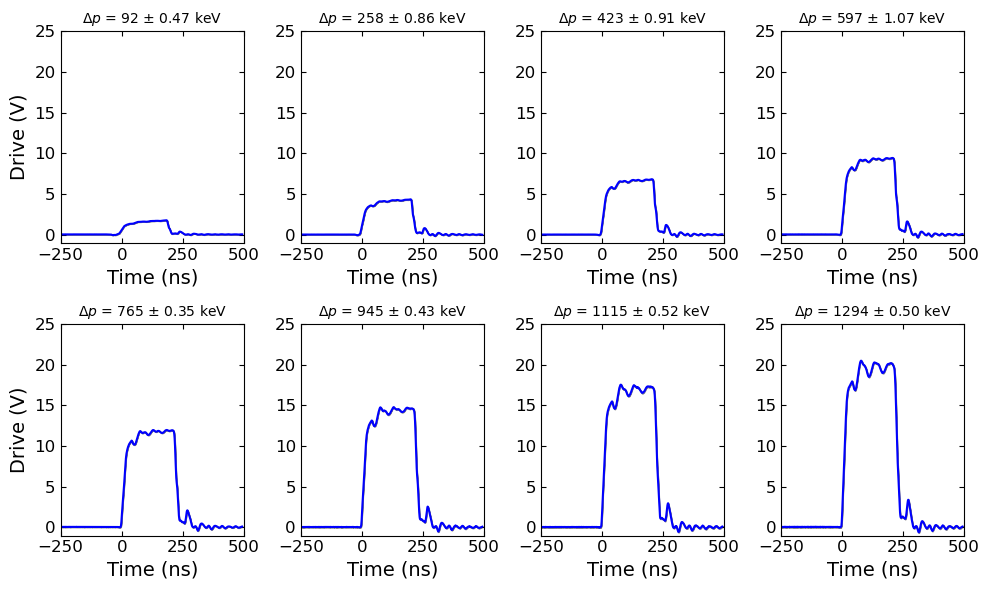

In [7]:
charge = 8
efield = 128 # V/m

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i in range(8):
    ax = axes.flatten()[i]

    amp_kev = charge * aas_mean[i] * 128 * 1.602e-19 * utils.SI2ev / 1000
    amp_kev_std = charge * aas_std[i] * 128 * 1.602e-19 * utils.SI2ev / 1000
    
    ax.fill_between(tt*1e9, dds_mean[i]-dds_std[i], dds_mean[i]+dds_std[i], color='grey', alpha=0.95)
    ax.plot(tt*1e9, dds_mean[i], color='blue')
    
    ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)

    ax.set_xlim(-250, 500)
    ax.set_ylim(-1, 25)
    
    if i == 0 or i == 4:
        ax.set_ylabel('Drive (V)')

    ax.set_xlabel('Time (ns)')

fig.tight_layout()

## Averaged `amp2keV`=7381.747090660193 derived from ~1,000 pulses at 1.3 MeV

In [8]:
sphere = 'sphere_20241202'
data_folder = ['20241204_8e', '20241205_8e', '20241209_8e_alignment1_1', '20241213_8e_alignment2_4', '20241213_8e_alignment2_5']
dataset_prefixs = ['20241204_dg_8e_200ns_', '20241205_dg_8e_200ns_', '20241209_dg_8e_200ns_', '20241213_dg_8e_200ns_', '20241213_dg_8e_200ns_']
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]
unnormalized_amps_all = [[] for i in range(len(voltages))]

for i, v in enumerate(voltages):
    for j, f in enumerate(data_folder):
        # First dataset does not have 2.5 V data
        if v == 2.5 and f == '20241204_8e':
            continue

        folder = f'/Volumes/LaCie/pulse_calibration/{sphere}/{f}'
        dataset = dataset_prefixs[j] + f'{v}v'

        combined_path = os.path.join(folder, f'{dataset}*.hdf5')
        data_files = glob.glob(combined_path)
        print(combined_path)

        unnormalized_amps_all[i].append(utils.get_unnormalized_amps(data_files, noise=False))

/Volumes/LaCie/pulse_calibration/sphere_20241202/20241205_8e/20241205_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241209_8e_alignment1_1/20241209_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241213_8e_alignment2_4/20241213_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241213_8e_alignment2_5/20241213_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241204_8e/20241204_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241205_8e/20241205_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241209_8e_alignment1_1/20241209_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241213_8e_alignment2_4/20241213_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241213_8e_alignment2_5/20241213_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241204_8e/20241204_dg_8e_200ns_7.5v*.hdf5
/V

In [9]:
# Perform the same search on noise only data
datasets = ['20241204_dg_8e_200ns_5v', '20241205_dg_8e_200ns_5v', '20241209_dg_8e_200ns_5v', '20241213_dg_8e_200ns_5v', '20241213_dg_8e_200ns_5v']

unnormalized_amps_noise = []
for i, f in enumerate(data_folder):
    folder = f'/Volumes/LaCie/pulse_calibration/{sphere}/{f}'
    dataset = datasets[i]

    combined_path = os.path.join(folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)
    print(combined_path)

    unnormalized_amps_noise.append(utils.get_unnormalized_amps(data_files, True))

/Volumes/LaCie/pulse_calibration/sphere_20241202/20241204_8e/20241204_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241205_8e/20241205_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241209_8e_alignment1_1/20241209_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241213_8e_alignment2_4/20241213_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20241202/20241213_8e_alignment2_5/20241213_dg_8e_200ns_5v*.hdf5


In [10]:
unnormalized_amps_all_flattened = []
for i in range(len(voltages)):
    unnormalized_amps_all_flattened.append(np.asarray([a for amps in unnormalized_amps_all[i] for a in amps]))

bins = np.arange(0, 2500, 50) / 7381.747090660193
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)

unnormalized_amps_noise_flattened = np.asarray([a for amps in unnormalized_amps_noise for a in amps])
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7008/3495388871.py:18: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=f'1294 $\pm$ {1294*0.05:.0f} keV/c')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7008/3

Averaged `amp2keV`: 7382.459966198711


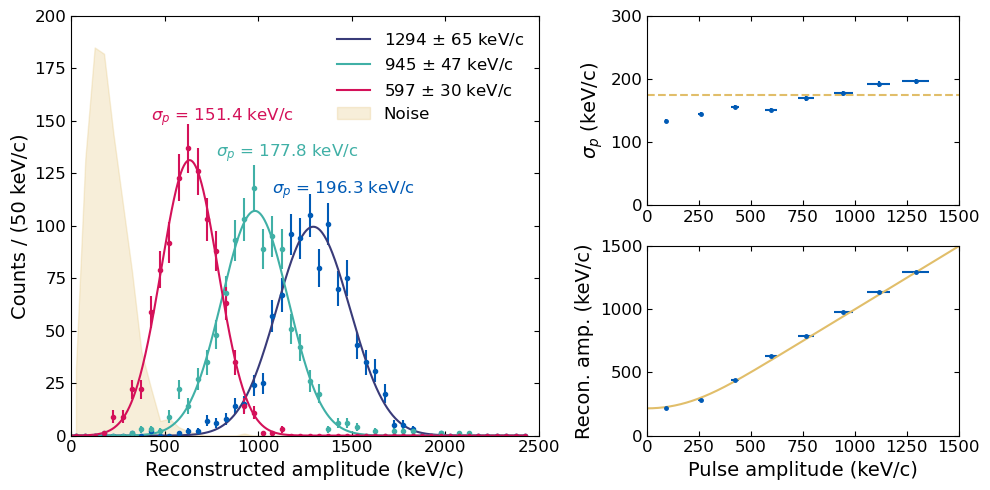

In [ ]:
from matplotlib.gridspec import GridSpec
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05
n_pulses = np.asarray([amps.size for amps in unnormalized_amps_all_flattened])

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[3])

# First plot
ax = ax0
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 / gps[7][1]

ax.errorbar(bcs[0]*amp2kev_all, hhs[7], yerr=np.sqrt(hhs[7]), fmt='.', color='#005AB5')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=f'1294 $\pm$ {1294*0.05:.0f} keV/c')

ax.errorbar(bcs[0]*amp2kev_all, hhs[5], yerr=np.sqrt(hhs[5]), fmt='.', color='#40B0A6')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[5]), label=f'945 $\pm$ {945*0.05:.0f} keV/c', color='#40B0A6')

ax.errorbar(bcs[0]*amp2kev_all, hhs[3], yerr=np.sqrt(hhs[3]), fmt='.', color='#D41159')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[3]), label=f'597 $\pm$ {597*0.05:.0f} keV/c', color='#D41159')

ax.fill_between(bcs[0]*amp2kev_all, hh_noise, color='#E1BE6A', alpha=0.25, label='Noise')

ax.text(1075, 115, f'$\sigma_p$ = {gps[7][2]*amp2kev_all:.1f} keV/c', color='#005AB5', fontsize=12)
ax.text(775, 132.5, f'$\sigma_p$ = {gps[5][2]*amp2kev_all:.1f} keV/c', color='#40B0A6', fontsize=12)
ax.text(425, 150, f'$\sigma_p$ = {gps[3][2]*amp2kev_all:.1f} keV/c', color='#D41159', fontsize=12)

ax.legend(frameon=False, fontsize=12)
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel(f'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)
ax.set_ylim(0, 200)

# Second plot fo resolution
ax = ax1
sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
ax.errorbar(pulseamps, sig_p_avg, yerr=sig_p_avg/np.sqrt(2 * (n_pulses-1)), xerr=pulseamps_err, 
            fmt='.', markersize=5, color='#005AB5')

# idx_fit = pulseamps > 400
# f = lambda x, a, b: a * x + b
# popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[0.1, 100], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
# xx = np.linspace(0, 4000, 500)
# ax.plot(xx, f(xx, *popt_sig), '--', color='#E1BE6A')

# Fit with a horizontal line instead
idx_fit = pulseamps > 500
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
xx = np.linspace(0, 4000, 500)
ax.plot(xx, np.full_like(xx, popt_sig[0]), '--', color='#E1BE6A')


ax.set_ylim(0, 300)
ax.set_xlim(0, 1500)
# ax.set_xlabel('Pulse amplitude (keV/c)')
ax.set_ylabel('$\sigma_p$ (keV/c)')


# Third plot for search bias
ax = ax2
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = 170 / amp2kev_all # Resolution in amplitude for plotting (not keV)
alpha = 1.1

xx = np.linspace(0, 1500, 500)

ax.errorbar(pulseamps, amps*amp2kev_all, yerr=amps_std*amp2kev_all/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color='#005AB5')
ax.plot(xx, search_expectation(xx, alpha, amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all, color='#E1BE6A')
# axes[1].plot(xx, search_expectation(xx, 1.1, amp2kev_all, sig_amp) * amp2kev_all, color='#E1BE6A', 
#              label=f'$\sigma_p$={sig_amp*amp2kev_all:.0f} keV/c, $\sigma_b$ = {sig_amp*alpha*amp2kev_all:.0f} keV/c')

# ax.legend(frameon=False)
ax.set_ylim(0, 1500)
ax.set_xlim(0, 1500)
ax.set_xlabel('Pulse amplitude (keV/c)')
ax.set_ylabel('Recon. amp. (keV/c)')

fig.tight_layout()

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/impulse_calibration_demo.pdf', dpi=600)

# This value is slightly different from the one used
# in analysis (7381.747090660193) because of the binning
# but the difference is negligible
print(f'Averaged `amp2keV`: {amp2kev_all}')

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64556/1280054732.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=f'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/c', color=colors[i])


Text(0, 0.5, 'Counts / (50 keV/c)')

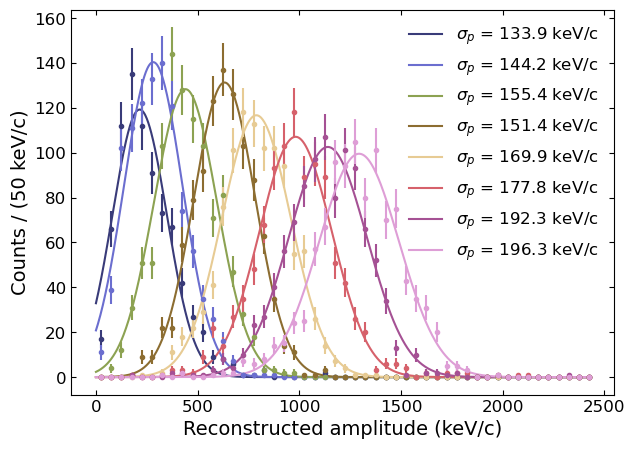

In [86]:
colors = plt.colormaps.get_cmap('tab20b').resampled(8).colors

fig, ax = plt.subplots(figsize=(7, 5))

xx = np.linspace(0, np.max(bcs[0]), 1000)
for i in range(8):
    ax.errorbar(bcs[0]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=f'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/c', color=colors[i])

ax.legend(frameon=False)
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel(f'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

## Derive the efficiency curve from the combined dataset

In [53]:
def gaus_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def func_fit_eff(x, a, b):
    sig_fit = a * x + b
    
    xvec = np.linspace(5 * sig_fit, 10000, 500)
    ret = np.trapz(gaus_pdf(xvec, x, sig_fit), x=xvec, axis=0)

    return ret

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

In [72]:
normalized_amps_all = [a * amp2kev_all for a in unnormalized_amps_all_flattened]

sig_p_fit = popt_sig[0]
eff, eff_err = get_detection_efficiency(normalized_amps_all, np.full(8, sig_p_fit), 5)
popt, pcov = curve_fit(func2, pulseamps, eff, p0=[850, 0.001], sigma=eff_err, maxfev=5000)

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7008/2622147033.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.text(60, 0.77, f'$\sigma_p$ = {sig_p_fit:.2f} keV/c', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7008/2622147033.py:15: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('5-$\sigma_p$ signal efficiency')


[0.0037831021437578815, 0.0010030090270812437, 0.006018054162487462, 0.050100200400801605, 0.3132530120481928, 0.7180261832829808, 0.8984924623115578, 0.963819095477387]


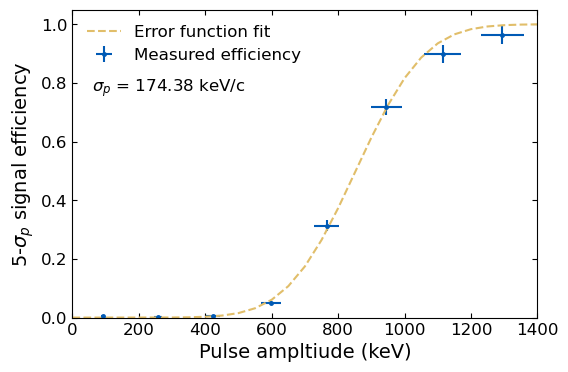

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

xx = np.arange(0, 10000, 50)
f = np.interp(xx, pulseamps, eff)

ax.errorbar(pulseamps, eff, yerr=eff_err, xerr=pulseamps_err, fmt='.', markersize=5, label='Measured efficiency', color='#005AB5')
ax.plot(xx, func2(xx, *popt), '--',label='Error function fit', color='#E1BE6A')

ax.text(60, 0.77, f'$\sigma_p$ = {sig_p_fit:.2f} keV/c', fontsize=12)

ax.legend(frameon=False)
ax.set_xlim(0, 1400)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Pulse ampltiude (keV)')
ax.set_ylabel('5-$\sigma_p$ signal efficiency')

print(eff)
# print(popt)

In [78]:
outfile_name = 'sphere_20241202_calibration_all.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('calibration_data_processed')
    for i, v in enumerate(voltages):
        g.create_dataset(f'unnormalized_amps_{str(v)}v', data=unnormalized_amps_all_flattened[i], dtype=np.float64)
        g.create_dataset(f'histogram_{str(v)}v', data=hhs[i], dtype=np.int16)
        g.create_dataset(f'gp_{str(v)}v', data=gps[i], dtype=np.float64)
        if i ==0:
            g.create_dataset(f'bc', data=bcs[i], dtype=np.float64)

    g.create_dataset(f'unnormalized_amps_noise_5v', data=unnormalized_amps_noise_flattened, dtype=np.float64)
    g.create_dataset(f'histogram_noise_5v', data=hh_noise, dtype=np.int16)

    g.create_dataset(f'sig_efficiency_fit_params', data=popt, dtype=np.float64)

    fout.close()

## Process pulse calibration data ("Alignment 0")

In [49]:
folder = r'/Volumes/LaCie/pulse_calibration/20241204_8e'
datasets = ['20241204_dg_8e_200ns_5v', '20241204_dg_8e_200ns_7.5v', '20241204_dg_8e_200ns_10v', '20241204_dg_8e_200ns_12.5v', '20241204_dg_8e_200ns_15v', '20241204_dg_8e_200ns_17.5v', '20241204_dg_8e_200ns_20v']
pulseamps = np.asarray([248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241204_dg_8e_200ns_5v
20241204_dg_8e_200ns_7.5v
20241204_dg_8e_200ns_10v
20241204_dg_8e_200ns_12.5v
20241204_dg_8e_200ns_15v
20241204_dg_8e_200ns_17.5v
20241204_dg_8e_200ns_20v


(0.0, 2500.0)

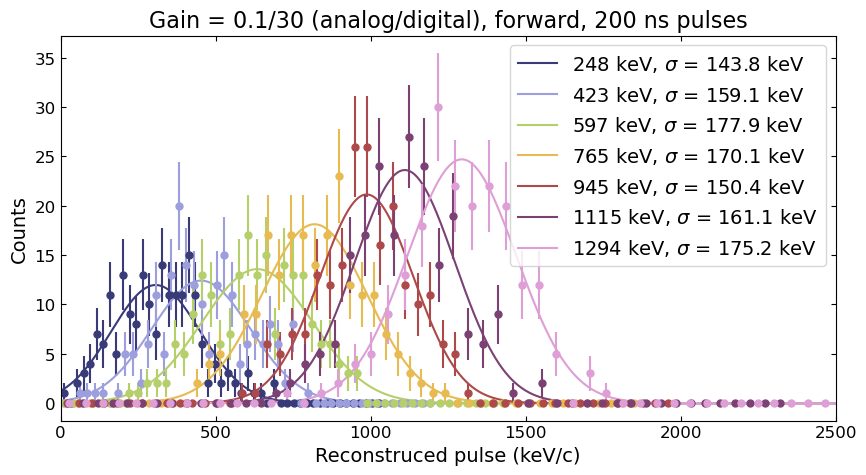

In [50]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/4145541470.py:18: SyntaxWarning: invalid escape sequence '\s'
  axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

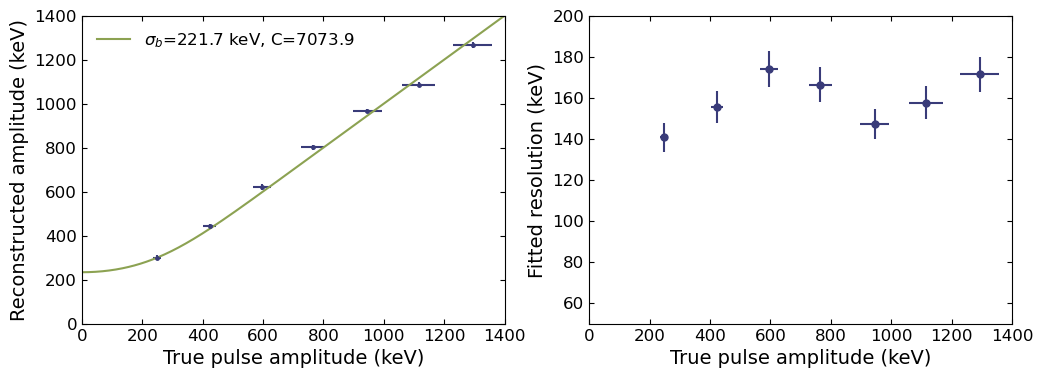

In [51]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = np.mean(amps_std[-3:]) # Resolution in amplitude (not keV)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

In [52]:
folder = r'/Volumes/LaCie/pulse_calibration/20241205_8e'
datasets = ['20241205_dg_8e_200ns_2.5v', '20241205_dg_8e_200ns_5v', '20241205_dg_8e_200ns_7.5v', '20241205_dg_8e_200ns_10v', '20241205_dg_8e_200ns_12.5v', '20241205_dg_8e_200ns_15v', '20241205_dg_8e_200ns_17.5v', '20241205_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241205_dg_8e_200ns_2.5v
20241205_dg_8e_200ns_5v
20241205_dg_8e_200ns_7.5v
20241205_dg_8e_200ns_10v
20241205_dg_8e_200ns_12.5v
20241205_dg_8e_200ns_15v
20241205_dg_8e_200ns_17.5v
20241205_dg_8e_200ns_20v


(0.0, 2500.0)

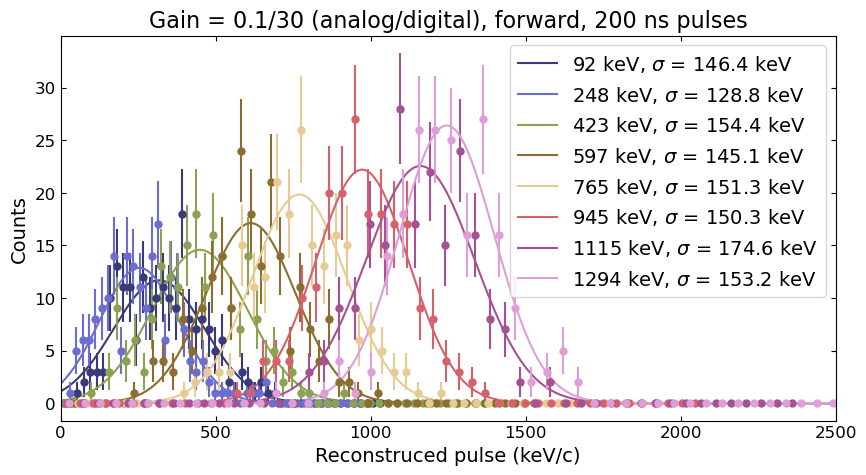

In [53]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [54]:
# Now fit the noise data
unnormalized_amps_noise = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, True)

20241205_dg_8e_200ns_2.5v
20241205_dg_8e_200ns_5v
20241205_dg_8e_200ns_7.5v
20241205_dg_8e_200ns_10v
20241205_dg_8e_200ns_12.5v
20241205_dg_8e_200ns_15v
20241205_dg_8e_200ns_17.5v
20241205_dg_8e_200ns_20v


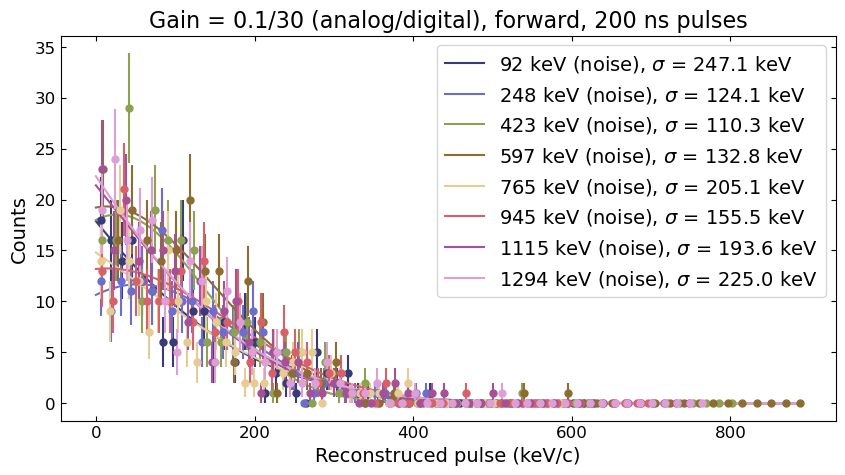

In [55]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus(unnormalized_amps_noise, True)
normalized_amps_noise = [amp * amp2kev for amp in unnormalized_amps_noise]

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps_noise, hhs_noise, bcs_noise, gps_noise, amp2kev=amp2kev, noise=True, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/4145541470.py:18: SyntaxWarning: invalid escape sequence '\s'
  axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

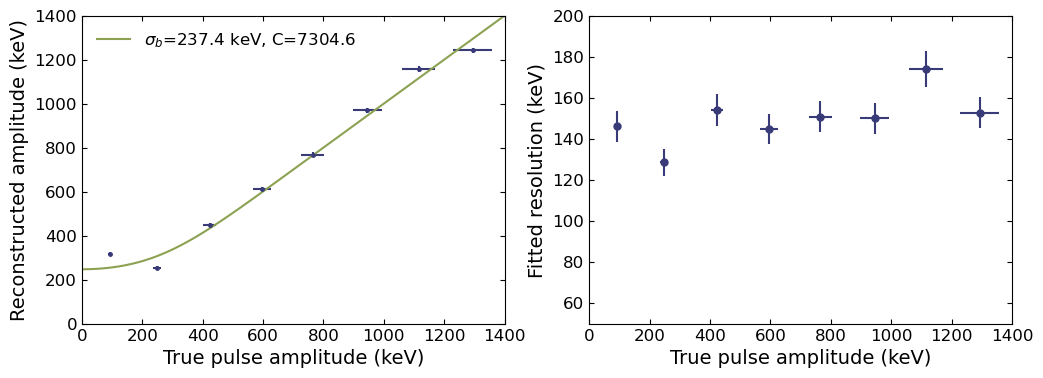

In [56]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = np.mean(amps_std[-3:]) # Resolution in amplitude (not keV)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

Derive efficiency curve

In [217]:
sigma_p = sig_amp * amp2kev_fit

eff, eff_err = get_detection_efficiency(normalized_amps, sigma_p, 5)
popt, pcov = curve_fit(func_fit_eff, pulseamps, eff, p0=[700, *popt_sig], maxfev=5000)
# popt, pcov = curve_fit(func, pulseamps, eff, p0=[1, 0, 0, 0.005], maxfev=5000)

NameError: name 'amp2kev_fit' is not defined

[0.0, 0.0, 0.010050251256281407, 0.115, 0.425, 0.8944723618090452, 1.0, 0.9949748743718593]
[7.84055941e+02 5.08842959e-03]


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/516957347.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.text(54, 0.77, f'$\sigma_p$ = {sigma_p:.2f} keV', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/516957347.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('5-$\sigma_p$ signal efficiency')


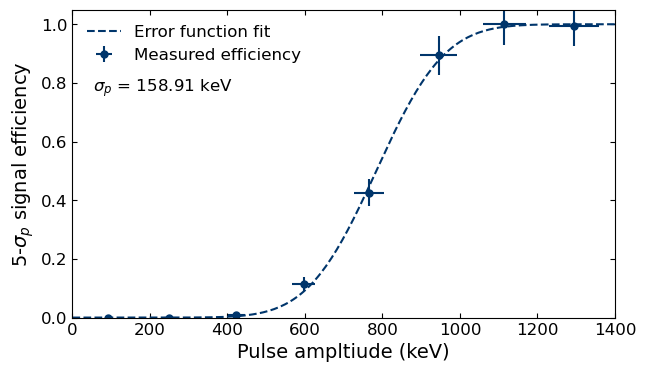

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# f = interp1d(pulseamps, detection_efficiency, 'linear')

xx = np.linspace(0, 1400, 200)
ax.errorbar(pulseamps, eff, yerr=eff_err, xerr=pulseamps_err, fmt='.', markersize=10, label='Measured efficiency', color=yale_colors[0])
ax.plot(xx, func2(xx, *popt), '--',label='Error function fit', color=yale_colors[0])
ax.text(54, 0.77, f'$\sigma_p$ = {sigma_p:.2f} keV', fontsize=12)

ax.legend(frameon=False)
ax.set_xlim(0, 1400)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Pulse ampltiude (keV)')
ax.set_ylabel('5-$\sigma_p$ signal efficiency')

print(eff)
print(popt)

## Initial anlignment ("Alignment 0"), after a few days (do not use -- charge is likely off)
The first calibration dataset doesn't look good, likely there is environmental coupling such as folks talking
The subsequent dataset does not show significantly degraded resolution, but the `amp2kev` factor does go higher, meaning that the reconstructed pulse amplitudes are smaller than before

In [104]:
folder = r'/Volumes/LaCie/pulse_calibration/20241209_8e'
datasets = ['20241209_dg_8e_200ns_2.5v', '20241209_dg_8e_200ns_5v', '20241209_dg_8e_200ns_7.5v', '20241209_dg_8e_200ns_10v', '20241209_dg_8e_200ns_12.5v', '20241209_dg_8e_200ns_15v', '20241209_dg_8e_200ns_17.5v', '20241209_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241209_dg_8e_200ns_2.5v
20241209_dg_8e_200ns_5v
20241209_dg_8e_200ns_7.5v
20241209_dg_8e_200ns_10v
20241209_dg_8e_200ns_12.5v
20241209_dg_8e_200ns_15v
20241209_dg_8e_200ns_17.5v
20241209_dg_8e_200ns_20v


(0.0, 2500.0)

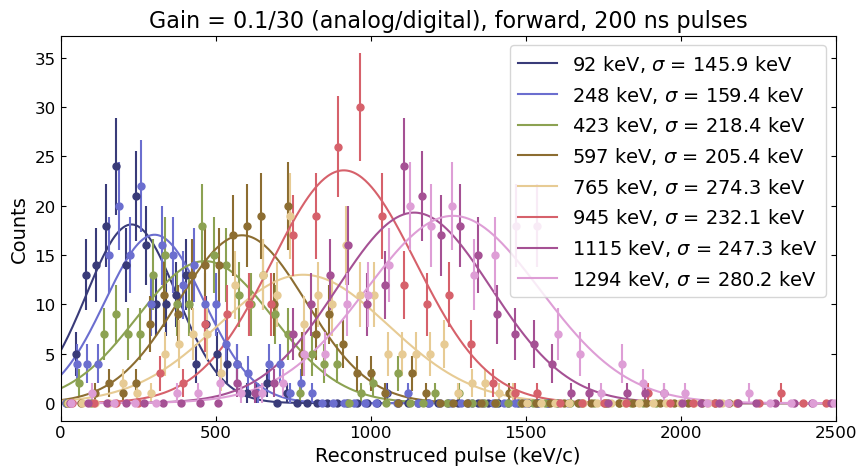

In [105]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [106]:
amp2kev

11158.528662204975

In [101]:
folder = r'/Volumes/LaCie/pulse_calibration/20241209_8e_1'
datasets = ['20241209_dg_8e_200ns_2.5v', '20241209_dg_8e_200ns_5v', '20241209_dg_8e_200ns_7.5v', '20241209_dg_8e_200ns_10v', '20241209_dg_8e_200ns_12.5v', '20241209_dg_8e_200ns_15v', '20241209_dg_8e_200ns_17.5v', '20241209_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241209_dg_8e_200ns_2.5v
20241209_dg_8e_200ns_5v
20241209_dg_8e_200ns_7.5v
20241209_dg_8e_200ns_10v
20241209_dg_8e_200ns_12.5v
20241209_dg_8e_200ns_15v
20241209_dg_8e_200ns_17.5v
20241209_dg_8e_200ns_20v


(0.0, 2500.0)

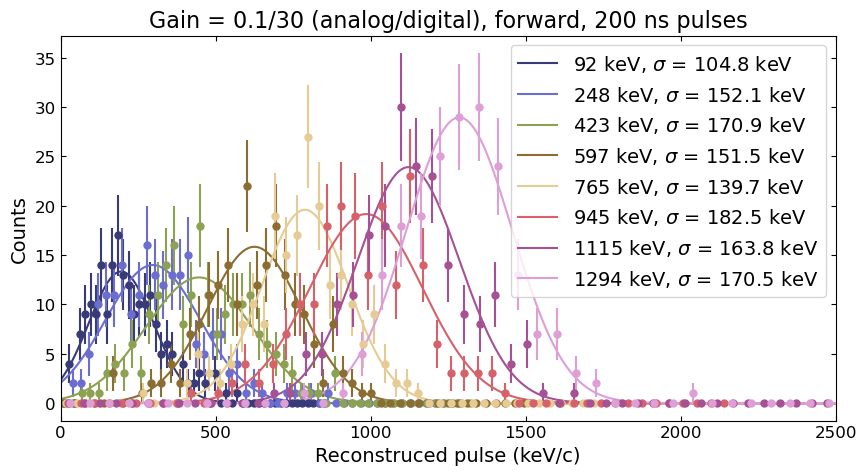

In [102]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/3845497049.py:18: SyntaxWarning: invalid escape sequence '\s'
  axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

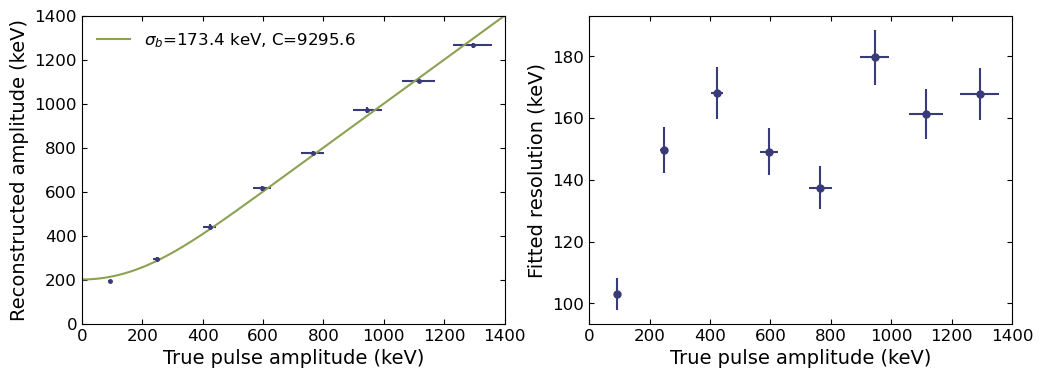

In [63]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = np.mean(amps_std[-3:]) # Resolution in amplitude (not keV)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
# axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

### Realigned the backscatter detection ("Alignment 1")
First measurement seems to get the charge wrong. It is also unclear why the resolution is a lot worse. However, after charging the sphere to +8e and calibrate again we recover the previously achieved noise level

In [64]:
folder = r'/Volumes/LaCie/pulse_calibration/20241209_6e_alignment1'
datasets = ['20241209_dg_8e_200ns_2.5v', '20241209_dg_8e_200ns_5v', '20241209_dg_8e_200ns_7.5v', '20241209_dg_8e_200ns_10v', '20241209_dg_8e_200ns_12.5v', '20241209_dg_8e_200ns_15v', '20241209_dg_8e_200ns_17.5v', '20241209_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294]) * 6 / 8
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241209_dg_8e_200ns_2.5v
20241209_dg_8e_200ns_5v
20241209_dg_8e_200ns_7.5v
20241209_dg_8e_200ns_10v
20241209_dg_8e_200ns_12.5v
20241209_dg_8e_200ns_15v
20241209_dg_8e_200ns_17.5v
20241209_dg_8e_200ns_20v


(0.0, 2500.0)

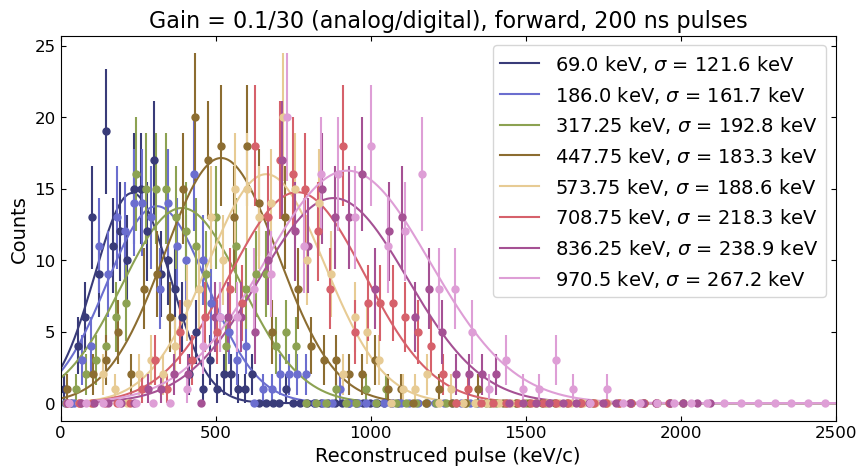

In [65]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [66]:
folder = r'/Volumes/LaCie/pulse_calibration/20241209_8e_alignment1_1'
datasets = ['20241209_dg_8e_200ns_2.5v', '20241209_dg_8e_200ns_5v', '20241209_dg_8e_200ns_7.5v', '20241209_dg_8e_200ns_10v', '20241209_dg_8e_200ns_12.5v', '20241209_dg_8e_200ns_15v', '20241209_dg_8e_200ns_17.5v', '20241209_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241209_dg_8e_200ns_2.5v
20241209_dg_8e_200ns_5v
20241209_dg_8e_200ns_7.5v
20241209_dg_8e_200ns_10v
20241209_dg_8e_200ns_12.5v
20241209_dg_8e_200ns_15v
20241209_dg_8e_200ns_17.5v
20241209_dg_8e_200ns_20v


(0.0, 2500.0)

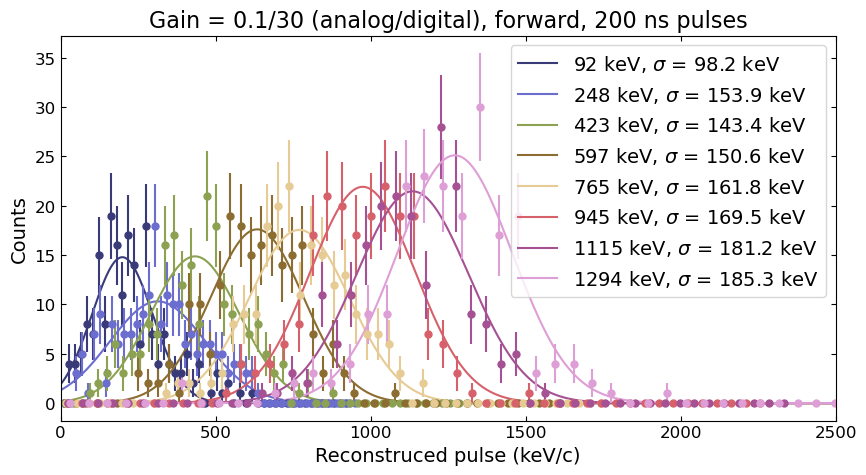

In [67]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/4196270323.py:19: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

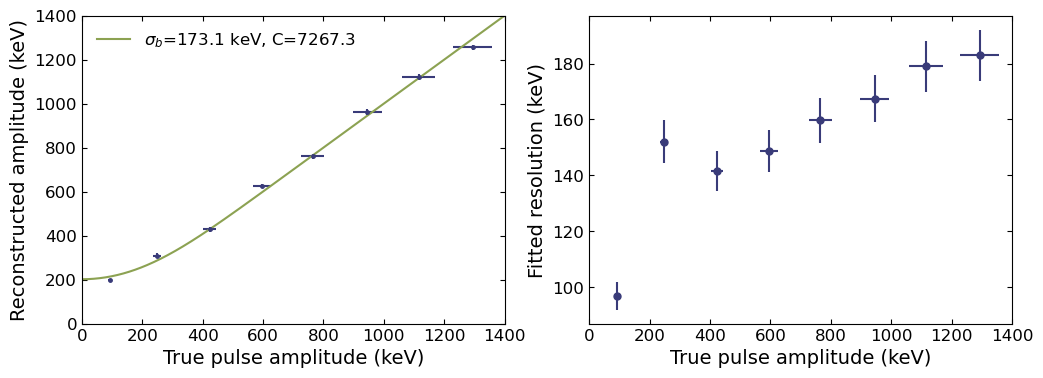

In [68]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = np.mean(amps_std[-4:]) # Resolution in amplitude (not keV)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], 
             label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
# axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

## Realigned backscatter detection ("Alignment 2")

In [69]:
folder = r'/Volumes/LaCie/pulse_calibration/20241210_8e_alignment2'
datasets = ['20241210_dg_8e_200ns_2.5v', '20241210_dg_8e_200ns_5v', '20241210_dg_8e_200ns_7.5v', '20241210_dg_8e_200ns_10v', '20241210_dg_8e_200ns_12.5v', '20241210_dg_8e_200ns_15v', '20241210_dg_8e_200ns_17.5v', '20241210_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241210_dg_8e_200ns_2.5v
20241210_dg_8e_200ns_5v
20241210_dg_8e_200ns_7.5v
20241210_dg_8e_200ns_10v
20241210_dg_8e_200ns_12.5v
20241210_dg_8e_200ns_15v
20241210_dg_8e_200ns_17.5v
20241210_dg_8e_200ns_20v


(0.0, 2500.0)

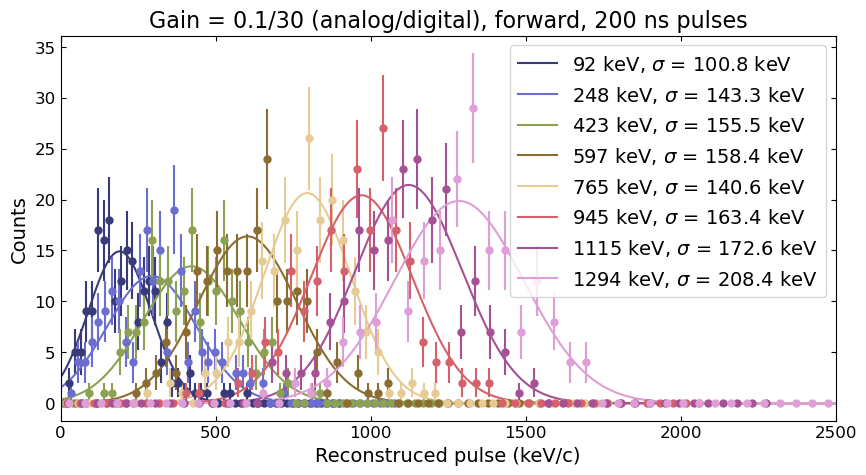

In [70]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/4196270323.py:19: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

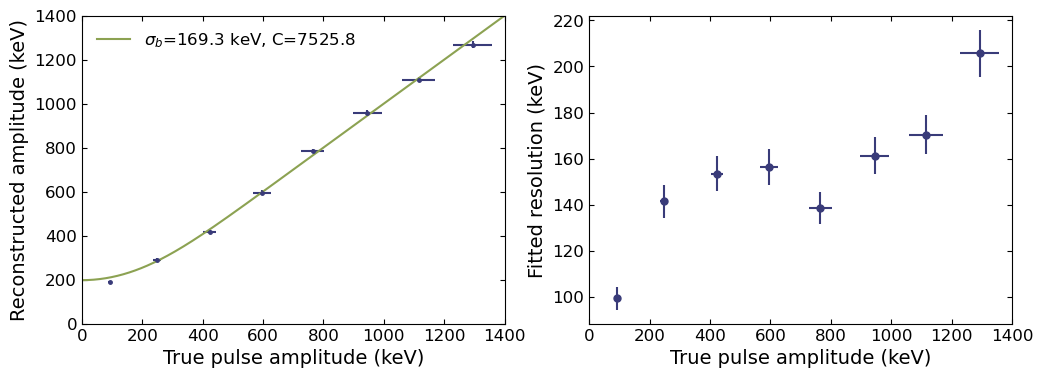

In [71]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = np.mean(amps_std[-4:]) # Resolution in amplitude (not keV)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], 
             label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
# axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

In [72]:
sigma_p = sig_amp * amp2kev_fit

eff, eff_err = get_detection_efficiency(normalized_amps, sigma_p, 5)
popt, pcov = curve_fit(func2, pulseamps, eff, p0=[700, 0.005], maxfev=5000)

[0.0, 0.0, 0.0, 0.06, 0.345, 0.745, 0.9346733668341709, 0.9798994974874372]
[8.36192028e+02 4.20819285e-03]


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/516957347.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.text(54, 0.77, f'$\sigma_p$ = {sigma_p:.2f} keV', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/516957347.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('5-$\sigma_p$ signal efficiency')


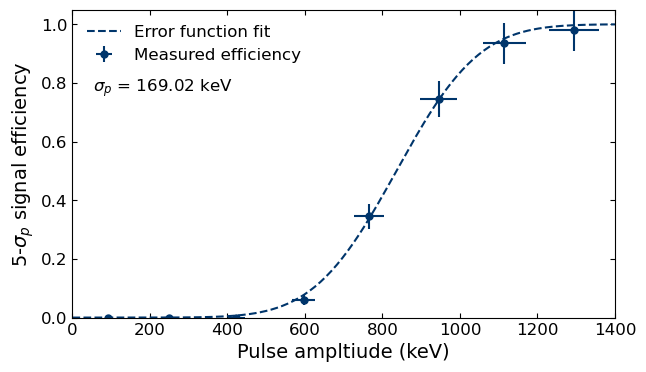

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# f = interp1d(pulseamps, detection_efficiency, 'linear')

xx = np.linspace(0, 1400, 200)
ax.errorbar(pulseamps, eff, yerr=eff_err, xerr=pulseamps_err, fmt='.', markersize=10, label='Measured efficiency', color=yale_colors[0])
ax.plot(xx, func2(xx, *popt), '--',label='Error function fit', color=yale_colors[0])
ax.text(54, 0.77, f'$\sigma_p$ = {sigma_p:.2f} keV', fontsize=12)

ax.legend(frameon=False)
ax.set_xlim(0, 1400)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Pulse ampltiude (keV)')
ax.set_ylabel('5-$\sigma_p$ signal efficiency')

print(eff)
print(popt)

In [74]:
folder = r'/Volumes/LaCie/pulse_calibration/20241211_8e_alignment2_1'
datasets = ['20241211_dg_8e_200ns_2.5v', '20241211_dg_8e_200ns_5v', '20241211_dg_8e_200ns_7.5v', '20241211_dg_8e_200ns_10v', '20241211_dg_8e_200ns_12.5v', '20241211_dg_8e_200ns_15v', '20241211_dg_8e_200ns_17.5v', '20241211_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241211_dg_8e_200ns_2.5v
20241211_dg_8e_200ns_5v
20241211_dg_8e_200ns_7.5v
20241211_dg_8e_200ns_10v
20241211_dg_8e_200ns_12.5v
20241211_dg_8e_200ns_15v
20241211_dg_8e_200ns_17.5v
20241211_dg_8e_200ns_20v


(0.0, 2500.0)

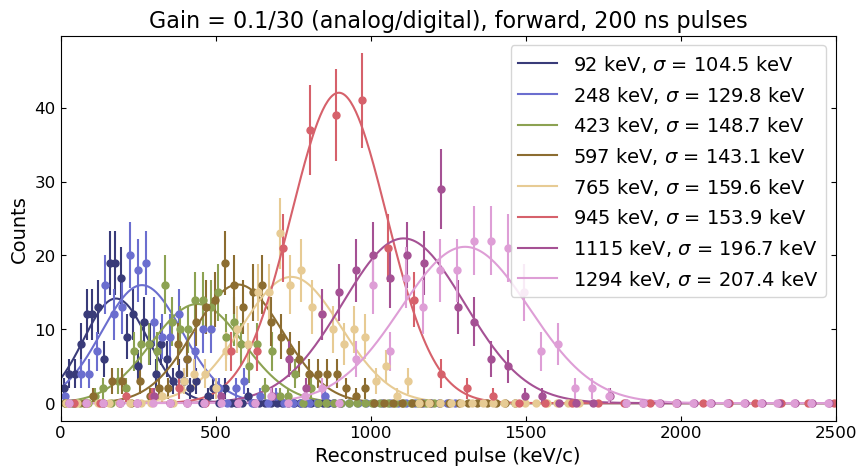

In [75]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/4196270323.py:19: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

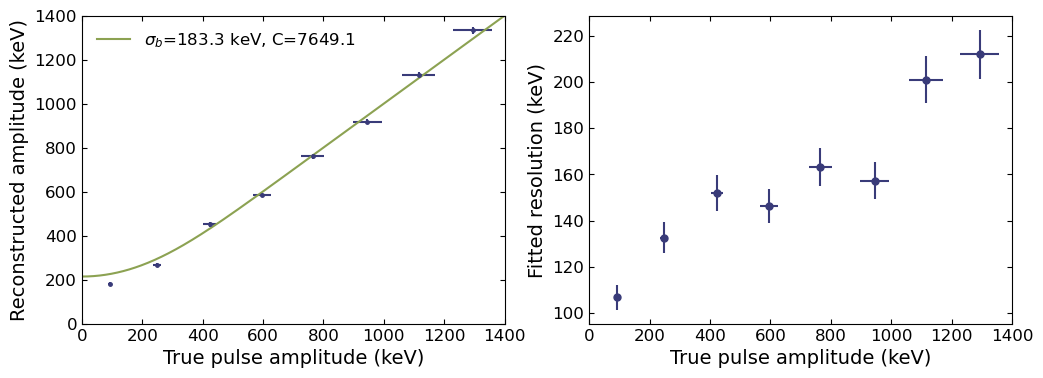

In [76]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

sig_amp = np.mean(amps_std[-4:]) # Resolution in amplitude (not keV)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], 
             label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
# axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

## Reversed polarity calibration run

The first dataset has issues of homodyne detection losing lock at the end of the calibration, so will not use these results

In [77]:
folder = r'/Volumes/LaCie/pulse_calibration/20241212_8e_alignment2_2_reversed_polarity'
datasets = ['20241212_dg_8e_200ns_2.5v', '20241212_dg_8e_200ns_5v', '20241212_dg_8e_200ns_7.5v', '20241212_dg_8e_200ns_10v', '20241212_dg_8e_200ns_12.5v', '20241212_dg_8e_200ns_15v', '20241212_dg_8e_200ns_17.5v', '20241212_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241212_dg_8e_200ns_2.5v
20241212_dg_8e_200ns_5v
20241212_dg_8e_200ns_7.5v
20241212_dg_8e_200ns_10v
20241212_dg_8e_200ns_12.5v
20241212_dg_8e_200ns_15v
20241212_dg_8e_200ns_17.5v
20241212_dg_8e_200ns_20v


(0.0, 2500.0)

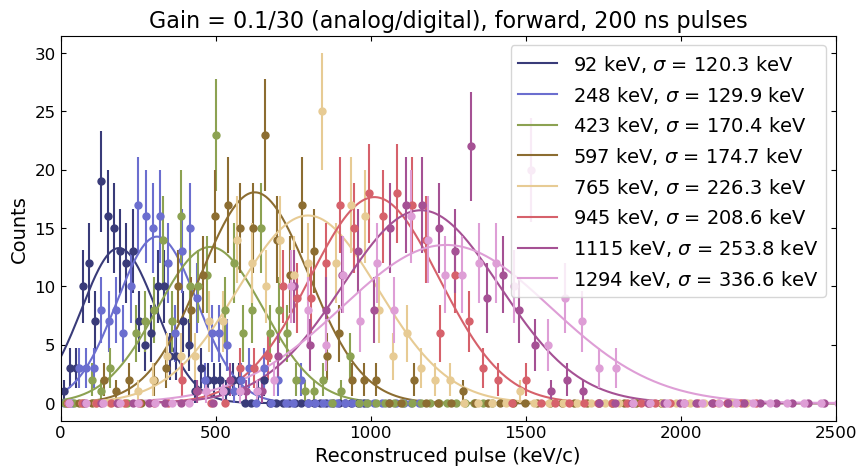

In [78]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [79]:
folder = r'/Volumes/LaCie/pulse_calibration/20241212_8e_alignment2_3_reversed_polarity'
datasets = ['20241212_dg_8e_200ns_2.5v', '20241212_dg_8e_200ns_5v', '20241212_dg_8e_200ns_7.5v', '20241212_dg_8e_200ns_10v', '20241212_dg_8e_200ns_12.5v', '20241212_dg_8e_200ns_15v', '20241212_dg_8e_200ns_17.5v', '20241212_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241212_dg_8e_200ns_2.5v
20241212_dg_8e_200ns_5v
20241212_dg_8e_200ns_7.5v
20241212_dg_8e_200ns_10v
20241212_dg_8e_200ns_12.5v
20241212_dg_8e_200ns_15v
20241212_dg_8e_200ns_17.5v
20241212_dg_8e_200ns_20v


(0.0, 2500.0)

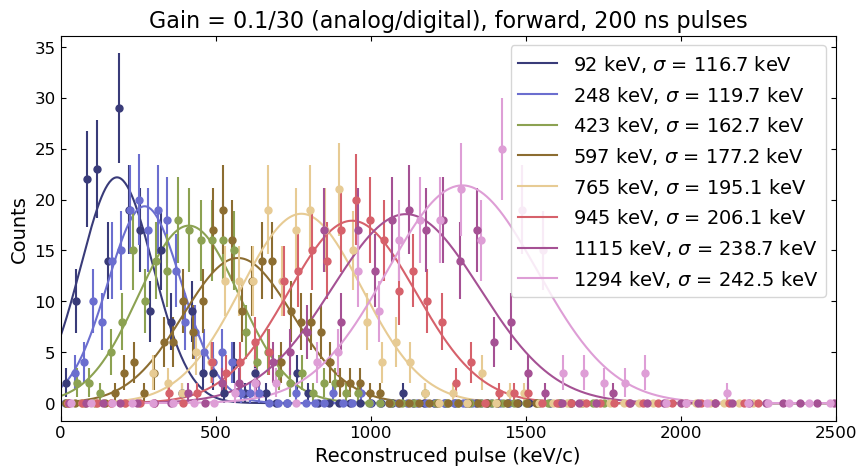

In [80]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [81]:
amp2kev

6861.898246027064

## Back to the polarity used for calibration before

In [107]:
folder = r'/Volumes/LaCie/pulse_calibration/20241213_8e_alignment2_4'
datasets = ['20241213_dg_8e_200ns_2.5v', '20241213_dg_8e_200ns_5v', '20241213_dg_8e_200ns_7.5v', '20241213_dg_8e_200ns_10v', '20241213_dg_8e_200ns_12.5v', '20241213_dg_8e_200ns_15v', '20241213_dg_8e_200ns_17.5v', '20241213_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241213_dg_8e_200ns_2.5v
20241213_dg_8e_200ns_5v
20241213_dg_8e_200ns_7.5v
20241213_dg_8e_200ns_10v
20241213_dg_8e_200ns_12.5v
20241213_dg_8e_200ns_15v
20241213_dg_8e_200ns_17.5v
20241213_dg_8e_200ns_20v


(0.0, 2500.0)

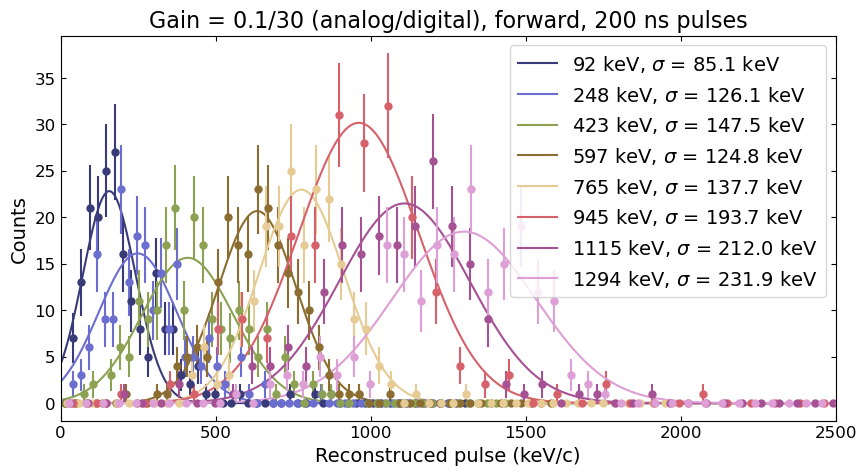

In [108]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [84]:
folder = r'/Volumes/LaCie/pulse_calibration/20241213_8e_alignment2_5'
datasets = ['20241213_dg_8e_200ns_2.5v', '20241213_dg_8e_200ns_5v', '20241213_dg_8e_200ns_7.5v', '20241213_dg_8e_200ns_10v', '20241213_dg_8e_200ns_12.5v', '20241213_dg_8e_200ns_15v', '20241213_dg_8e_200ns_17.5v', '20241213_dg_8e_200ns_20v']
pulseamps = np.asarray([92, 248, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241213_dg_8e_200ns_2.5v
20241213_dg_8e_200ns_5v
20241213_dg_8e_200ns_7.5v
20241213_dg_8e_200ns_10v
20241213_dg_8e_200ns_12.5v
20241213_dg_8e_200ns_15v
20241213_dg_8e_200ns_17.5v
20241213_dg_8e_200ns_20v


(0.0, 2500.0)

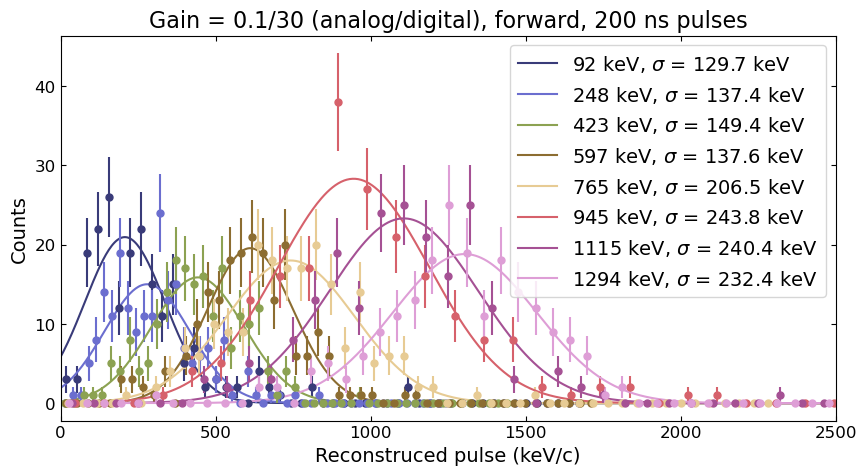

In [85]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_21326/2445943861.py:20: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')


Text(0, 0.5, 'Fitted resolution (keV)')

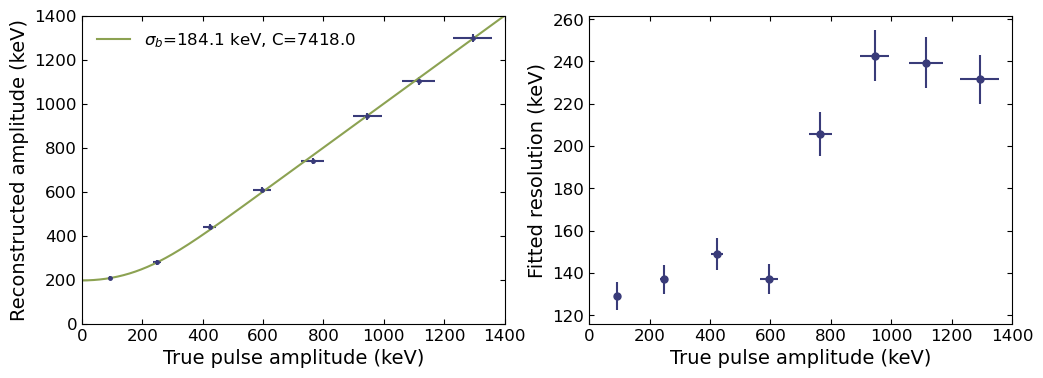

In [100]:
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

# sig_amp = np.mean(amps_std[-4:]) # Resolution in amplitude (not keV)
sig_amp = 140 / amp2kev

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.colormaps.get_cmap('tab20b').resampled(5).colors

popt, pcov = curve_fit(lambda x, a, b: search_expectation(x, a, b, sig_amp),
                       pulseamps, amps, p0=[1.2, amp2kev], 
                       sigma=amps_std*amp2kev/np.sqrt(n_pulses),
                       bounds=([1, amp2kev*0.8], [1.5, amp2kev*1.2]))

amp2kev_fit = popt[1]

xx = np.linspace(0, 1400, 500)
axes[0].errorbar(pulseamps, amps*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color=colors[0])
axes[0].plot(xx, search_expectation(xx, popt[0], popt[1], sig_amp) * popt[-1], color=colors[1], 
             label=f'$\sigma_b$={popt[0]*sig_amp*popt[1]:.1f} keV, C={popt[1]:.1f}')
axes[0].legend(frameon=False)

axes[0].set_ylim(0, 1400)
axes[0].set_xlim(0, 1400)
axes[0].set_xlabel('True pulse amplitude (keV)')
axes[0].set_ylabel('Reconstructed amplitude (keV)')

axes[1].errorbar(pulseamps, amps_std*amp2kev_fit, yerr=amps_std*amp2kev_fit/np.sqrt(2*n_pulses-2), xerr=pulseamps_err, fmt='.', color=colors[0], markersize=10)
# axes[1].set_ylim(50, 200)
axes[1].set_xlim(0, 1400)
axes[1].set_xlabel('True pulse amplitude (keV)')
axes[1].set_ylabel('Fitted resolution (keV)')

In [91]:
amp2kev

7447.535066241468

In [98]:
amp2kevs

[3307.762651520865,
 6618.751435472277,
 7118.816042673608,
 7271.135258525424,
 7678.65949884633,
 7446.730672057532,
 7501.9309046112485,
 7393.139227871686]